In [34]:
#%load_ext autoreload
#%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import re
import os
import sys
import datetime
import itertools
import warnings
import math

# deep learning
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import plot_model  

# data transforamtion and manipulation
import pandas as pd
import pandas_datareader.data as web
import numpy as np

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
#from arch import arch_model

import matplotlib.pyplot as plt
import matplotlib as mpl
plt.style.use('seaborn')

# remove warnings
import warnings
warnings.filterwarnings('ignore')

# prevent crazy long pandas prints
pd.options.display.max_columns = 16
pd.options.display.max_rows = 16
pd.set_option('display.float_format', lambda x: '%.5f' % x)
np.set_printoptions(precision=5, suppress=True)

# Display and Plotting
import matplotlib.pyplot as plt
#set_matplotlib_formats('pdf', 'png')
plt.rcParams['savefig.dpi'] = 80
plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = (16, 8)
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['text.usetex'] = False
#plt.rcParams['font.family'] = "serif"
plt.rcParams['font.serif'] = "cm"
plt.rcParams['text.latex.preamble'] = b"\usepackage{subdepth}, \usepackage{type1cm}"

import seaborn as sns
#sns.set_style("whitegrid", {'axes.grid' : False})

# Neural network forecasting

The very basic ingredient of any artificial neural network is the artificial neuron. They are not only named after their biological counterparts but also are modeled after the behavior of the neurons in our brain.

Time series prediction problems are inherently different from supervised learning problems in that obervastions posses a timely ordering and no observeable input. Thus, the time series prediction problem has to be converted into a regression problem.

A supervised learing problem requires data of the form $(y, X)$ where $y$ is the observeable output and $X$ is a matrix of input data which is assumed to cause the observed output.


## Multilayer Perceptron Regression

As previously, the data is sliced up into a <code>train</code> and <code>test</code> set to evaluate the performance of a two-year-ahead forecast.

In [35]:
np.random.seed(7)

In [36]:
df = pd.read_csv('./data/passengers.csv', sep=';', parse_dates=True, index_col=0)
data = df.values

# using keras often requires the data type float32
data = data.astype('float32')

# slice the data
train = data[0:120, :]
test = data[120:, :]

print(len(train), len(test))

120 24


The <code>create_data_matrix</code> function will be used to transform the time series into a regression problem. The <code>look_back</code> takes an integer which corresponds the the number of previous time steps to use as input variables to predict the next time period. The default value is one but will be changed in a next iteration.

With the default setting a data set will be created where $X$ is the number of passengers at time $t$ and $y$ is the number of passengers at time 4t+1$.

In [37]:
def create_data_matrix(data, look_back=1):
    X_data, y_data = [], []
    for row in range(len(data) - look_back - 1):
        add = data[row:(row + look_back), 0]
        X_data.append(add)
        y_data.append(data[row + look_back, 0])
    return np.array(X_data), np.array(y_data)

In [38]:
look_back = 1
X_train, y_train = create_data_matrix(train, look_back)
X_test, y_test = create_data_matrix(test, look_back)

In [39]:
X_train

array([[ 112.],
       [ 118.],
       [ 132.],
       [ 129.],
       [ 121.],
       [ 135.],
       [ 148.],
       [ 148.],
       [ 136.],
       [ 119.],
       [ 104.],
       [ 118.],
       [ 115.],
       [ 126.],
       [ 141.],
       [ 135.],
       [ 125.],
       [ 149.],
       [ 170.],
       [ 170.],
       [ 158.],
       [ 133.],
       [ 114.],
       [ 140.],
       [ 145.],
       [ 150.],
       [ 178.],
       [ 163.],
       [ 172.],
       [ 178.],
       [ 199.],
       [ 199.],
       [ 184.],
       [ 162.],
       [ 146.],
       [ 166.],
       [ 171.],
       [ 180.],
       [ 193.],
       [ 181.],
       [ 183.],
       [ 218.],
       [ 230.],
       [ 242.],
       [ 209.],
       [ 191.],
       [ 172.],
       [ 194.],
       [ 196.],
       [ 196.],
       [ 236.],
       [ 235.],
       [ 229.],
       [ 243.],
       [ 264.],
       [ 272.],
       [ 237.],
       [ 211.],
       [ 180.],
       [ 201.],
       [ 204.],
       [ 188.],
       [

In [40]:
y_train

array([ 118.,  132.,  129.,  121.,  135.,  148.,  148.,  136.,  119.,
        104.,  118.,  115.,  126.,  141.,  135.,  125.,  149.,  170.,
        170.,  158.,  133.,  114.,  140.,  145.,  150.,  178.,  163.,
        172.,  178.,  199.,  199.,  184.,  162.,  146.,  166.,  171.,
        180.,  193.,  181.,  183.,  218.,  230.,  242.,  209.,  191.,
        172.,  194.,  196.,  196.,  236.,  235.,  229.,  243.,  264.,
        272.,  237.,  211.,  180.,  201.,  204.,  188.,  235.,  227.,
        234.,  264.,  302.,  293.,  259.,  229.,  203.,  229.,  242.,
        233.,  267.,  269.,  270.,  315.,  364.,  347.,  312.,  274.,
        237.,  278.,  284.,  277.,  317.,  313.,  318.,  374.,  413.,
        405.,  355.,  306.,  271.,  306.,  315.,  301.,  356.,  348.,
        355.,  422.,  465.,  467.,  404.,  347.,  305.,  336.,  340.,
        318.,  362.,  348.,  363.,  435.,  491.,  505.,  404.,  359.,  310.], dtype=float32)

The data set now has the following form
<pre>
X       y
112     118
118     132
132     129
129     121
121     135
</pre>
That is, the function has successfully shifted the data for one time step and saved this new shifted series to an array.

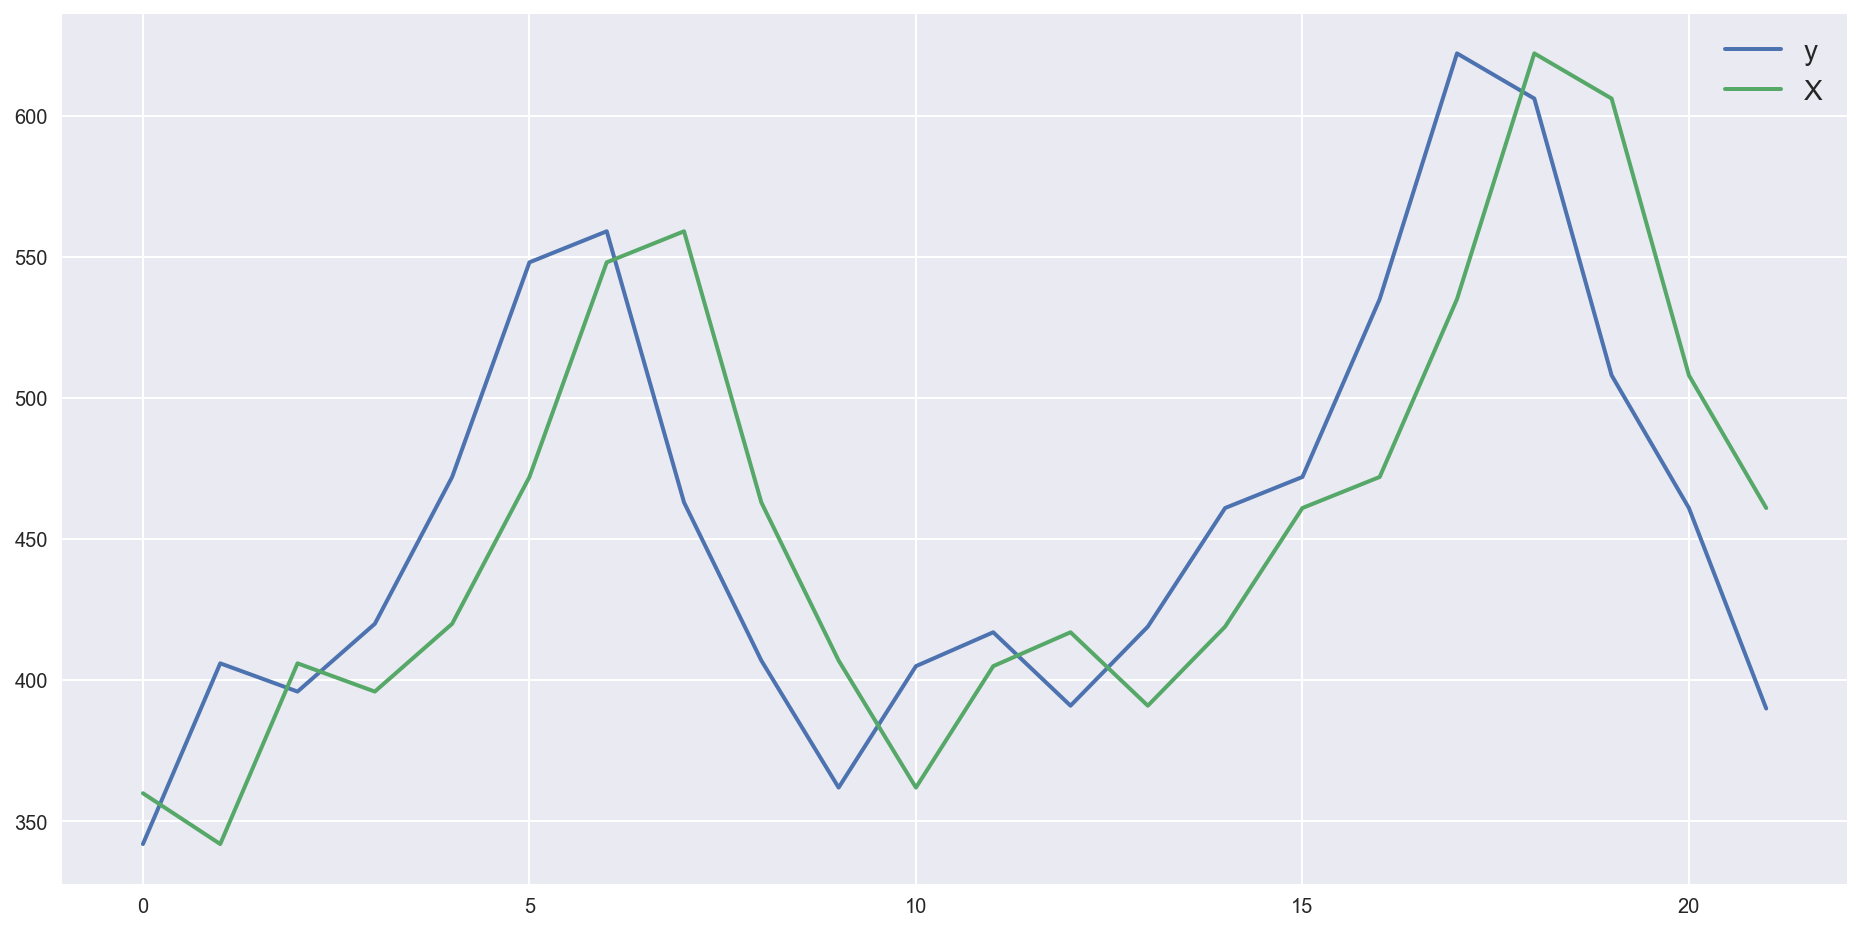

In [41]:
# plot the created data
plt.plot(y_test, label='y')
plt.plot(X_test, label='X')
plt.legend()
plt.show()

The first simple entwork will have one input (size of the <code>look_bacl</code> variable), one hidden layer with 8 neurons and an output layer. The model is fitted using the MSE criterion and rectified linear units as activation function

In [42]:
# create and fit Multilayer Perceptron model
mdl = Sequential()
mdl.add(Dense(8, input_dim=look_back, activation='relu'))
mdl.add(Dense(1))
mdl.compile(loss='mean_squared_error', optimizer='adam')
mdl.fit(X_train, y_train, epochs=200, batch_size=2, verbose=2)

Epoch 1/200
0s - loss: 64464.7533
Epoch 2/200
0s - loss: 54682.9765
Epoch 3/200
0s - loss: 44619.0103
Epoch 4/200
0s - loss: 34459.4926
Epoch 5/200
0s - loss: 24881.3372
Epoch 6/200
0s - loss: 16632.2823
Epoch 7/200
0s - loss: 10202.2320
Epoch 8/200
0s - loss: 5845.9799
Epoch 9/200
0s - loss: 3190.2769
Epoch 10/200
0s - loss: 1823.5140
Epoch 11/200
0s - loss: 1202.3505
Epoch 12/200
0s - loss: 949.6254
Epoch 13/200
0s - loss: 861.5730
Epoch 14/200
0s - loss: 840.2645
Epoch 15/200
0s - loss: 829.5898
Epoch 16/200
0s - loss: 829.4183
Epoch 17/200
0s - loss: 829.8610
Epoch 18/200
0s - loss: 825.5631
Epoch 19/200
0s - loss: 826.1766
Epoch 20/200
0s - loss: 827.8873
Epoch 21/200
0s - loss: 831.7821
Epoch 22/200
0s - loss: 827.2398
Epoch 23/200
0s - loss: 826.7124
Epoch 24/200
0s - loss: 824.1508
Epoch 25/200
0s - loss: 825.6400
Epoch 26/200
0s - loss: 831.9005
Epoch 27/200
0s - loss: 824.5790
Epoch 28/200
0s - loss: 827.5411
Epoch 29/200
0s - loss: 830.5045
Epoch 30/200
0s - loss: 830.7226
E

In [43]:
# Estimate model performance
train_score = mdl.evaluate(X_train, y_train, verbose=0)
print('Train Score: {:.2f} MSE ({:.2f} RMSE)'.format(train_score, math.sqrt(train_score)))
test_score = mdl.evaluate(X_test, y_test, verbose=0)
print('Test Score: {:.2f} MSE ({:.2f} RMSE)'.format(test_score, math.sqrt(test_score)))

Train Score: 816.13 MSE (28.57 RMSE)
Test Score: 2799.35 MSE (52.91 RMSE)


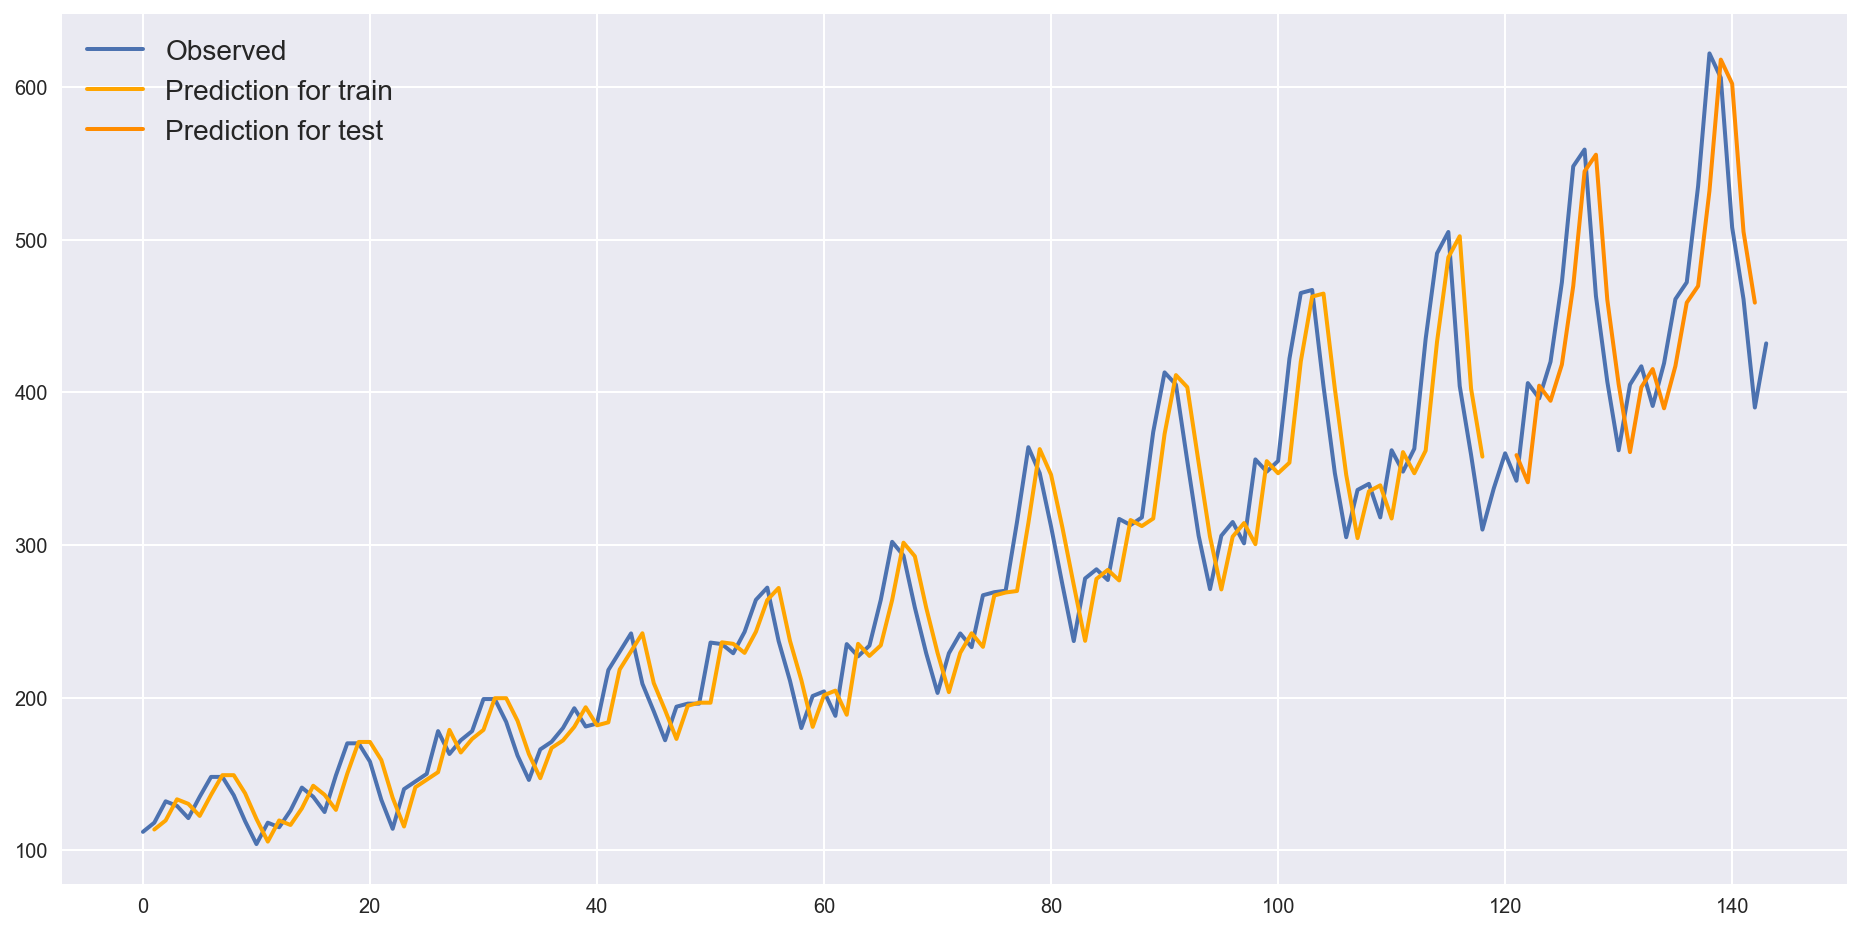

In [44]:
# generate predictions for training
train_predict = mdl.predict(X_train)
test_predict = mdl.predict(X_test)

# shift train predictions for plotting
train_predict_plot = np.empty_like(data)
train_predict_plot[:, :] = np.nan
train_predict_plot[look_back: len(train_predict) + look_back, :] = train_predict

# shift test predictions for plotting
test_predict_plot = np.empty_like(data)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict)+(look_back*2)+1:len(data)-1, :] = test_predict

# plot baseline and predictions
plt.plot(data, label='Observed');
plt.plot(train_predict_plot, label='Prediction for train', color='orange');
plt.plot(test_predict_plot, label='Prediction for test', color='darkorange');
plt.legend(loc='best');
plt.show()

Since the neural network has only be fed by the last observation, it did not have much choice but to learn to apply  observation $t$ for the prediction of $t+1$.

## Multilayer perceptron with window

In [45]:
# reshape dataset
look_back = 3
X_train, y_train = create_data_matrix(train, look_back)
X_test, y_test = create_data_matrix(test, look_back)

In [46]:
# create and fit Multilayer Perceptron model
mdl = Sequential()
mdl.add(Dense(12, input_dim=look_back, activation='relu'))
mdl.add(Dense(8, activation='relu'))
mdl.add(Dense(1))
mdl.compile(loss='mean_squared_error', optimizer='adam')
mdl.fit(X_train, y_train, epochs=400, batch_size=2, verbose=2)

Epoch 1/400
0s - loss: 3649.6979
Epoch 2/400
0s - loss: 1847.1070
Epoch 3/400
0s - loss: 1722.7844
Epoch 4/400
0s - loss: 1600.6418
Epoch 5/400
0s - loss: 1520.6950
Epoch 6/400
0s - loss: 1324.7880
Epoch 7/400
0s - loss: 1266.6480
Epoch 8/400
0s - loss: 1246.6147
Epoch 9/400
0s - loss: 1125.0117
Epoch 10/400
0s - loss: 1160.9100
Epoch 11/400
0s - loss: 1079.8765
Epoch 12/400
0s - loss: 1067.4753
Epoch 13/400
0s - loss: 983.2985
Epoch 14/400
0s - loss: 937.5277
Epoch 15/400
0s - loss: 904.0718
Epoch 16/400
0s - loss: 873.2370
Epoch 17/400
0s - loss: 870.4340
Epoch 18/400
0s - loss: 940.4649
Epoch 19/400
0s - loss: 892.2557
Epoch 20/400
0s - loss: 826.5885
Epoch 21/400
0s - loss: 771.9094
Epoch 22/400
0s - loss: 855.4348
Epoch 23/400
0s - loss: 813.4719
Epoch 24/400
0s - loss: 811.5894
Epoch 25/400
0s - loss: 780.7599
Epoch 26/400
0s - loss: 770.8412
Epoch 27/400
0s - loss: 809.5879
Epoch 28/400
0s - loss: 756.4754
Epoch 29/400
0s - loss: 798.1123
Epoch 30/400
0s - loss: 770.4634
Epoch 3

0s - loss: 743.7714
Epoch 247/400
0s - loss: 785.0538
Epoch 248/400
0s - loss: 817.2160
Epoch 249/400
0s - loss: 782.7658
Epoch 250/400
0s - loss: 729.0122
Epoch 251/400
0s - loss: 770.1008
Epoch 252/400
0s - loss: 754.7661
Epoch 253/400
0s - loss: 766.4243
Epoch 254/400
0s - loss: 707.4941
Epoch 255/400
0s - loss: 863.8403
Epoch 256/400
0s - loss: 760.5110
Epoch 257/400
0s - loss: 748.9226
Epoch 258/400
0s - loss: 741.7425
Epoch 259/400
0s - loss: 766.7060
Epoch 260/400
0s - loss: 769.8296
Epoch 261/400
0s - loss: 754.0392
Epoch 262/400
0s - loss: 720.9760
Epoch 263/400
0s - loss: 782.5703
Epoch 264/400
0s - loss: 728.5357
Epoch 265/400
0s - loss: 781.6966
Epoch 266/400
0s - loss: 712.6770
Epoch 267/400
0s - loss: 744.4658
Epoch 268/400
0s - loss: 727.0944
Epoch 269/400
0s - loss: 724.4794
Epoch 270/400
0s - loss: 730.8047
Epoch 271/400
0s - loss: 753.7025
Epoch 272/400
0s - loss: 716.0586
Epoch 273/400
0s - loss: 753.0907
Epoch 274/400
0s - loss: 757.2884
Epoch 275/400
0s - loss: 763

In [18]:
# Estimate model performance
train_score = mdl.evaluate(X_train, y_train, verbose=0)
print('Train Score: {:.2f} MSE ({:.2f} RMSE)'.format(train_score, math.sqrt(train_score)))
test_score = mdl.evaluate(X_test, y_test, verbose=0)
print('Test Score: {:.2f} MSE ({:.2f} RMSE)'.format(test_score, math.sqrt(test_score)))

Train Score: 680.65 MSE (26.09 RMSE)
Test Score: 2134.33 MSE (46.20 RMSE)


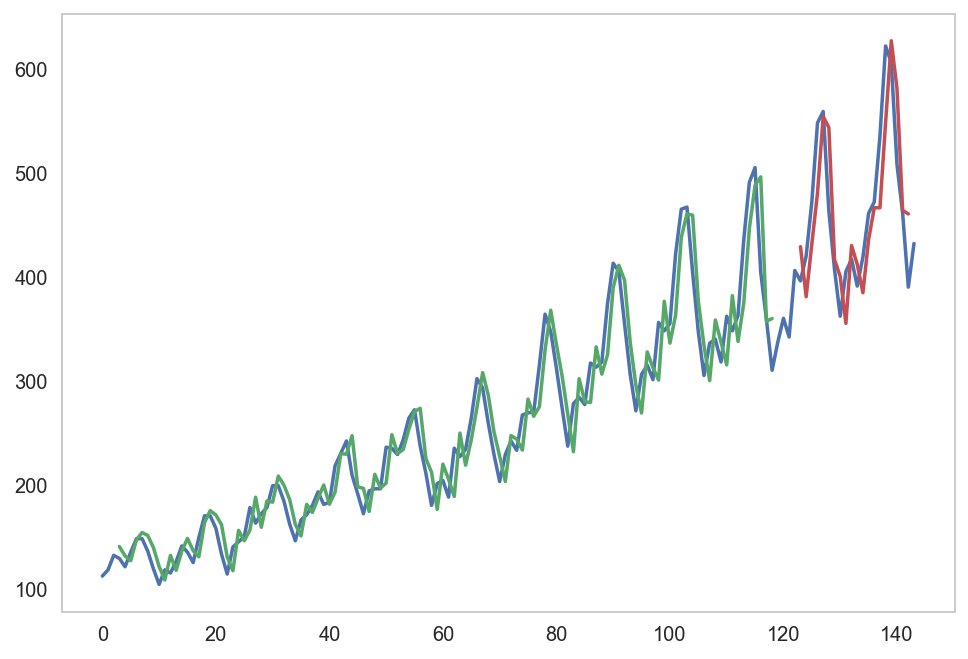

In [20]:
# generate predictions for training
train_predict = mdl.predict(X_train)
test_predict = mdl.predict(X_test)

# shift train predictions for plotting
train_predict_plot = np.empty_like(data)
train_predict_plot[:, :] = np.nan
train_predict_plot[look_back: len(train_predict) + look_back, :] = train_predict

# shift test predictions for plotting
test_predict_plot = np.empty_like(data)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict)+(look_back * 2)+1:len(data)-1, :] = test_predict

# plot baseline and predictions
plt.plot(data);
plt.plot(train_predict_plot);
plt.plot(test_predict_plot);
plt.show()